In [2]:
#  Copyright 2015 
#  Autor: Marcelo da P. dos Santos <marcelo_s7@hotmail.com>
#
#  Laboratorio de Espectroscopia Molecular (LEM)
#  Instituto de Quimica da Universidade de Sao Paulo
#
#     Gera o espectro Raman e IR em um arquivo ascii 
#     a partir do log do Gaussian
# 
#  This program is free software; you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published by
#  the Free Software Foundation; either version 2 of the License, or
#  (at your option) any later version.
#  
#  This program is distributed in the hope that it will be useful,
#  but WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details.
#  
#  You should have received a copy of the GNU General Public License
#  along with this program; if not, write to the Free Software
#  Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston,
#  MA 02110-1301, USA.
#  
#     To do:
#     - entrada de scaling e FWHM com defaults (feito).
#    modificado: frequencia final eh valor maximo da freq. + 200. Anterior
#    era fixo de 0 a 4000.
#    - acrescentando opcao para fitting de lorentziana
#   bug corrigido: faltou multiplicação do scaling.
#   python 3   print, raw_input, xrange retirados 03/2019 
#   03/2019 gui open file dialog
#   03/2019 bug latex anaconda3

In [ ]:
#### RUN ALL UNTIL ENTRY INPUT FILE CELL #####

In [2]:
###############################################
import sys, getopt, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
### gui dialog ###
from tkinter import Tk   ### T capital for python 2.7
from tkinter.filedialog import askopenfilename
###############################################
global NAtoms
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=False)  ### False, because anaconda3 latex bug.
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16,5)

In [3]:
def create_matrix(N):
    freq_matrix=np.zeros(shape=[3*N-6,7])
    return freq_matrix

In [4]:
def leitura(linhas):
    num_linha=0
    data_spec=[]
    count_freq = -1
    for line in linhas:
        num_linha = num_linha + 1
        words = line.split()  ###
        if len(words) >0:
            if words[0] =='NAtoms=':
                    NAtoms = int(words[1])
                    data_spec=create_matrix(NAtoms);
            if words[0] =='Frequencies'and words[1]=='--':
                    count_freq += 1
                    data_spec[0+count_freq*3][0]=float(words[2])
                    data_spec[1+count_freq*3][0]=float(words[3])
                    data_spec[2+count_freq*3][0]=float(words[4])
            if words[0] == 'Red.':
                    data_spec[0+count_freq*3][1]=float(words[3])
                    data_spec[1+count_freq*3][1]=float(words[4])
                    data_spec[2+count_freq*3][1]=float(words[5])                
            if words[0] == 'Frc':
                    data_spec[0+count_freq*3][2]=float(words[3])
                    data_spec[1+count_freq*3][2]=float(words[4])
                    data_spec[2+count_freq*3][2]=float(words[5])
            if words[0]=='IR' and words[1]=='Inten':
                    data_spec[0+count_freq*3][3]=float(words[3])
                    data_spec[1+count_freq*3][3]=float(words[4])
                    data_spec[2+count_freq*3][3]=float(words[5])
            if words[0] == 'Raman' and words[1]=='Activ':
                    Ramandata_presente = True
                    data_spec[0+count_freq*3][4]=float(words[3])
                    data_spec[1+count_freq*3][4]=float(words[4])
                    data_spec[2+count_freq*3][4]=float(words[5])
            if words[0]== 'Depolar'and words[1]=='(P)':
                    #data_spec.append(words[3:6])
                    data_spec[0+count_freq*3][5]=float(words[3])
                    data_spec[1+count_freq*3][5]=float(words[4])
                    data_spec[2+count_freq*3][5]=float(words[5])
            if words[0]== 'Depolar'and words[1]=='(U)':
                    data_spec[0+count_freq*3][6]=float(words[3])
                    data_spec[1+count_freq*3][6]=float(words[4])
                    data_spec[2+count_freq*3][6]=float(words[5])
    return data_spec

In [5]:
def fitting(f,f1,Intens,sigma,distr):
	if distr =='g':
		spectro_result = Intens*np.exp(-0.5*np.square((f-f1)/sigma))
	elif distr == 'l':
		spectro_result = Intens/(1 +np.square((f-f1)/sigma))
	return spectro_result

In [6]:
def data_analise(data):
    max_freq = data[-1][0]
    Size= np.shape(data)
    scaling = float(input('scaling[default:0.9679] : ') or 0.9679)
    f = np.arange(1,max_freq*scaling+250,1) 
    FWHM = float(input('FWHM[default:5.0] : ') or 5.0)
    sigma = FWHM*0.84932
    distr = input('gaussiana (g) or lorentziana (l)[default:gaussian] : ') or 'g'
    sumspectro_ir = 0
    sumspectro_raman = 0
    if sum(data[0:,4]) > 0.01:
        Ramandata_presente= True
    else:
        Ramandata_presente= False
    print('Raman Spectrum',Ramandata_presente)
    for ii in range(0,Size[0]):
        spectro_ir = fitting(f,data[ii][0]*scaling,data[ii][3],sigma,distr)
        sumspectro_ir += spectro_ir
        if Ramandata_presente==True:
            spectro_raman = fitting(f,data[ii][0]*scaling,data[ii][4],sigma,distr)
            sumspectro_raman += spectro_raman
    if Ramandata_presente==True:
        final_spectra = np.vstack((f,sumspectro_ir,sumspectro_raman))
    else:
        final_spectra = np.vstack((f,sumspectro_ir))
    final_spectra = np.transpose(final_spectra)
    return final_spectra, scaling


In [21]:
#####  ENTRY INPUT FILE #####
#
#####        main       #####

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
inputfile = askopenfilename() # show an "Open" dialog box and return the path to the selected file

with open (inputfile, 'rt') as input_file:
    #contents = myfile.read()
    linhas = input_file.readlines()
    data = leitura(linhas)
    print(input_file)
    #print(linhas)
#np.savetxt(outputfile,spectro_final,fmt='%.8f')


<_io.TextIOWrapper name='C:/Users/Marcelo/Documents/Gaussian/gaussian/SO2.log' mode='rt' encoding='cp1252'>


In [22]:
spectro_final,scaling = data_analise(data)
xx= spectro_final[:,0]

peaks= np.around(data[:,0]*scaling,1).astype(int)
#print(peaks)
#print(peaks.size)
#print(spectro_final)

scaling[default:0.9679] : 1
FWHM[default:5.0] : 10
gaussiana (g) or lorentziana (l)[default:gaussian] : g
Raman Spectrum True
[ 502 1140 1337]
3
[[1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [2.00000000e+000 0.00000000e+000 0.00000000e+000]
 [3.00000000e+000 0.00000000e+000 0.00000000e+000]
 ...
 [1.58500000e+003 6.79620427e-183 3.84857217e-184]
 [1.58600000e+003 2.18379326e-184 1.23664411e-185]
 [1.58700000e+003 6.92047644e-186 3.91894534e-187]]


In [20]:
print(input_file)
print(spectro_final[485])

<_io.TextIOWrapper name='C:/Users/Marcelo/Documents/Gaussian/gaussian/SO2.log' mode='rt' encoding='cp1252'>
[486.          33.95648657   3.58158095]


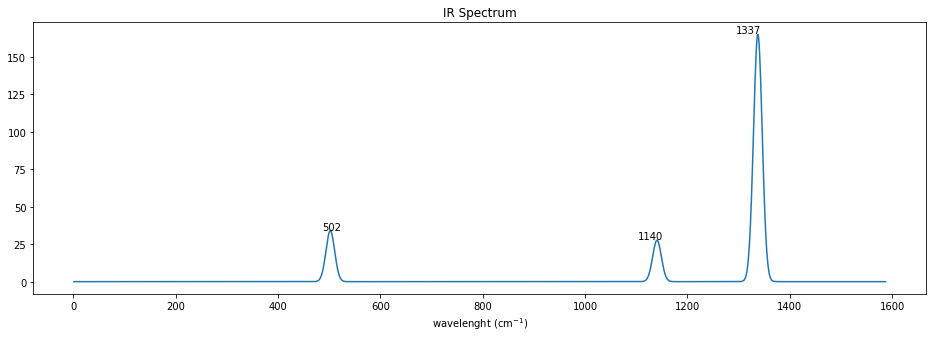

In [23]:
#plt.rc("text", usetex=False)  ### latex Bug Anaconda3 :( ###
plt.plot(xx, spectro_final[:,1])
plt.title('IR Spectrum')
plt.xlabel('wavelenght ($\mathrm{cm^{-1}}$)')
for ii in range(0,peaks.size ):
    plt.text(x_peaks[ii],spectro_final[peaks[ii],1]+1,np.str(peaks[ii]))
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


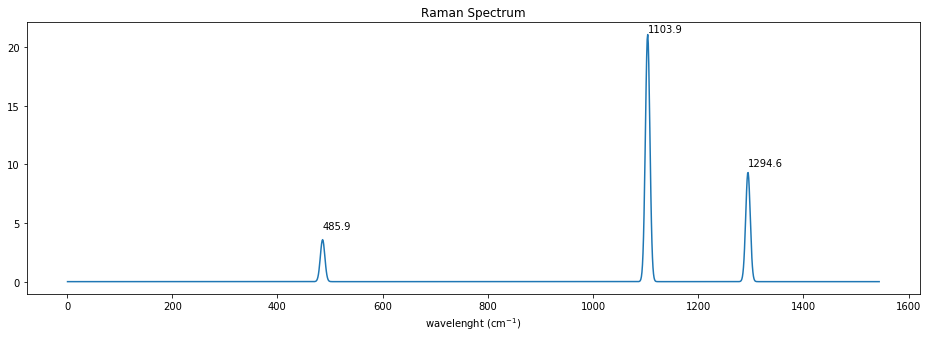

In [9]:
# ONLY WORKS IF THERE RAMAN DATA
plt.plot(xx, spectro_final[:,2])
plt.title('Raman Spectrum')
plt.xlabel(r'wavelenght ($\mathrm{cm^{-1}}$)')
for ii in range(0,peaks.size ):
    plt.text(x_peaks[ii],spectro_final[int(x_peaks[ii]),2]+1,np.str(peaks[ii]))
plt.show()